# Using a Modflow model as a stressmodel in Pastas

This notebook shows how to use a simple Modflow model as stress model in Pastas.

## Packages

In [1]:
import pandas as pd
import pastas as ps

from pastas.timer import SolveTimer
import pastas_plugins.modflow as ppmf

ps.set_log_level("ERROR")

## Data

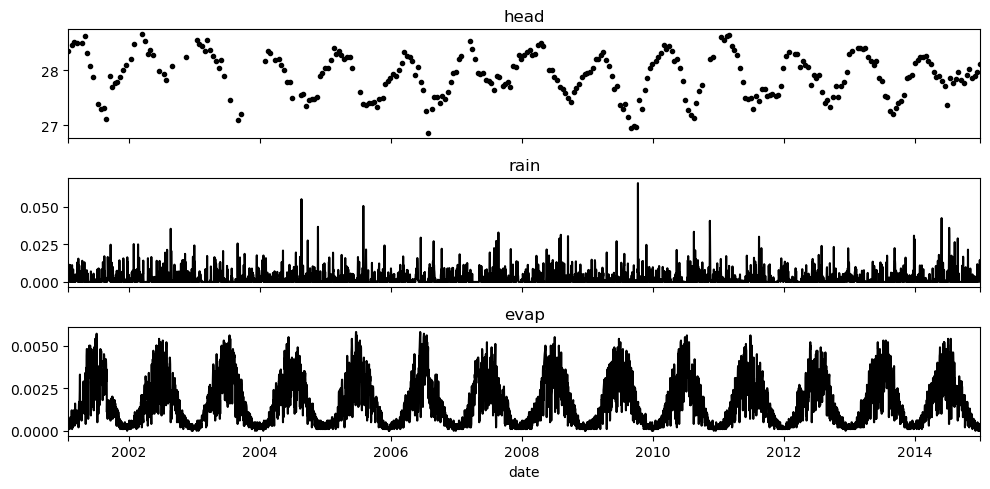

In [2]:
# %%
tmin = pd.Timestamp("2001-01-01")
tmax = pd.Timestamp("2014-12-31")

tmin_wu = tmin - pd.Timedelta(days=3651)
tmin_wu = pd.Timestamp("1986-01-01")

head = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",
        index_col="date",
        parse_dates=True,
    )
    .squeeze()
    .loc[tmin:tmax]
)
prec = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv",
        index_col="date",
        parse_dates=True,
    )
    .squeeze()
    .loc[tmin_wu:tmax]
)
evap = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv",
        index_col="date",
        parse_dates=True,
    )
    .squeeze()
    .loc[tmin_wu:tmax]
)

mf6_exe = "mf6"
ps.plots.series(head, [prec, evap], hist=False);

## Time series models

### Standard exponential model

Fit report head                   Fit Statistics
nfev    13                     EVP         93.50
nobs    295                    R2           0.94
noise   False                  RMSE         0.10
tmin    2001-01-28 00:00:00    AICc     -1365.07
tmax    2014-12-28 00:00:00    BIC      -1350.46
freq    D                      Obj          1.40
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal     initial  vary
test_exp_A  618.819090  219.247860  True
test_exp_a  183.492968   10.000000  True
test_exp_f   -1.618881   -1.000000  True
constant_d   28.248544   27.903864  True


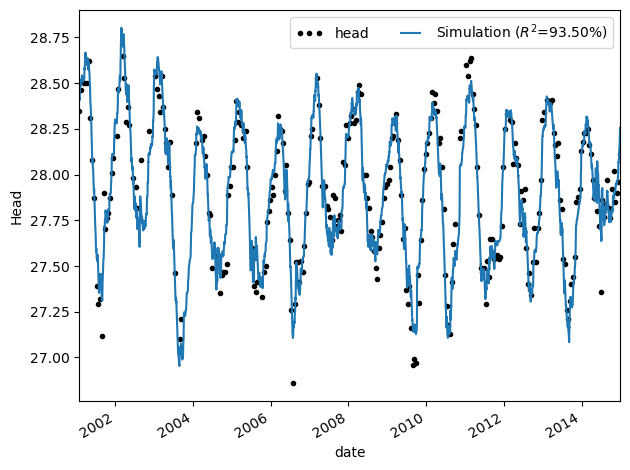

In [3]:
# %%
# create model with exponential response function
mlexp = ps.Model(head)
mlexp.add_stressmodel(
    ps.RechargeModel(prec=prec, evap=evap, rfunc=ps.Exponential(), name="test_exp")
)
mlexp.solve(tmin=tmin, tmax=tmax)
mlexp.plot();

### Uncalibrated MODFLOW time series model

Using parameters based on the Pastas Exponential model.

In [4]:
# %%
# extract resistance and sy from exponential model
# transform exponential parameters to modflow resistance and sy
mlexp_c = mlexp.parameters.loc["test_exp_A", "optimal"]
mlexp_c_i = mlexp.parameters.loc["test_exp_A", "initial"]
mlexp_sy = (
    mlexp.parameters.loc["test_exp_a", "optimal"]
    / mlexp.parameters.loc["test_exp_A", "optimal"]
)
mlexp_sy_i = (
    mlexp.parameters.loc["test_exp_a", "initial"]
    / mlexp.parameters.loc["test_exp_A", "initial"]
)
mlexp_d = mlexp.parameters.loc["constant_d", "optimal"]
mlexp_d_i = mlexp.parameters.loc["constant_d", "initial"]
mlexp_f = mlexp.parameters.loc["test_exp_f", "optimal"]
mlexp_f_i = mlexp.parameters.loc["test_exp_f", "initial"]

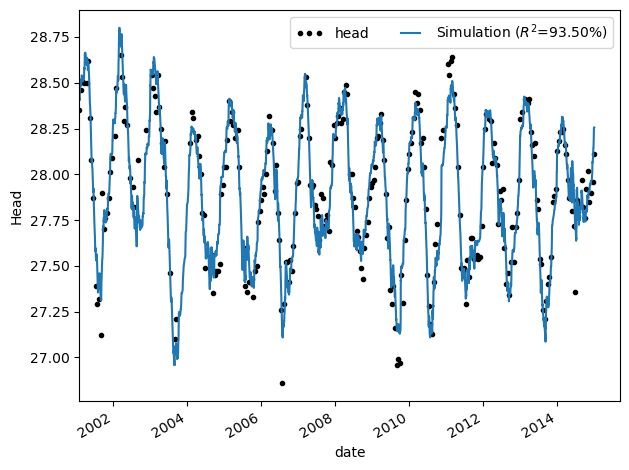

In [5]:
# create modflow pastas model with c and sy
mlexpmf = ps.Model(head)
# shorten the warmup to speed up the modflow calculation somewhat.
mlexpmf.settings["warmup"] = pd.Timedelta(days=4 * 365)
expmf = ppmf.ModflowRch(exe_name=mf6_exe, sim_ws="mf_files/test_expmf")
expsm = ppmf.ModflowModel([prec, evap], modflow=expmf, name="test_expmfsm")
mlexpmf.add_stressmodel(expsm)
mlexpmf.set_parameter(f"{expsm.name}_sy", initial=mlexp_sy, vary=False)
mlexpmf.set_parameter(f"{expsm.name}_c", initial=mlexp_c, vary=False)
mlexpmf.set_parameter(f"{expsm.name}_f", initial=mlexp_f, vary=False)
mlexpmf.set_parameter("constant_d", initial=mlexp_d, vary=False)
# mlexpmf.solve()
mlexpmf.plot(tmin=head.index[0]);

## Calibrated MODFLOW time series model

Now fit a Pastas Model using the Modflow model as a response function. This takes some
time, as the modflow model has to be recomputed for every iteration in the optimization
process.

In [6]:
ml = ps.Model(head)
# shorten the warmup to speed up the modflow calculation somewhat.
ml.settings["warmup"] = pd.Timedelta(days=4 * 365)
mf = ppmf.ModflowRch(exe_name=mf6_exe, sim_ws="mf_files/test_mfrch")
sm = ppmf.ModflowModel([prec, evap], modflow=mf, name="test_mfsm")
ml.add_stressmodel(sm)
ml.set_parameter(f"{sm.name}_sy", initial=mlexp_sy_i, vary=True)
ml.set_parameter(f"{sm.name}_c", initial=mlexp_c_i, vary=True)
ml.set_parameter(f"{sm.name}_f", initial=mlexp_f_i, vary=True)
ml.set_parameter("constant_d", initial=mlexp_d_i, vary=True)

solver = ps.LeastSquares()
with SolveTimer() as st:
    ml.solve(solver=solver, callback=st.timer, report=False, fit_constant=False)

Optimization progress: 0it [00:00, ?it/s]

<Axes: xlabel='date', ylabel='Head'>

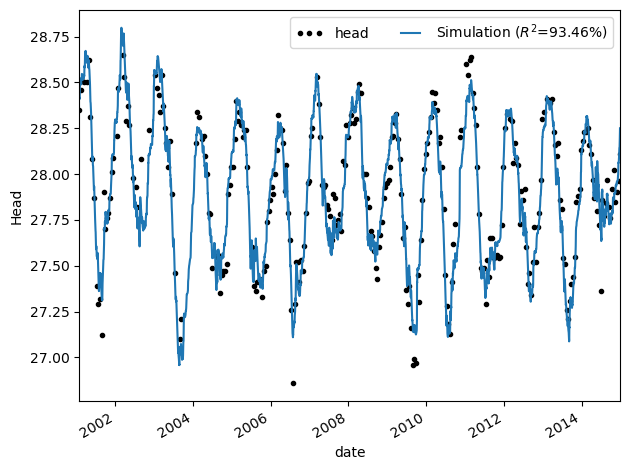

In [7]:
ml.plot();

## Results

### Parameters

In [8]:
ml.parameters.style.set_table_attributes('style="font-size: 12px"').set_caption(
    "Pastas-Modflow"
)

,initial,pmin,pmax,vary,name,dist,stderr,optimal
test_mfsm_sy,0.045610,0.001000,0.500000,True,test_mfsm,nan,0.003854,0.305121
test_mfsm_c,219.247860,10.000000,100000000.000000,True,test_mfsm,nan,20.281672,621.323787
test_mfsm_f,-1.000000,-2.000000,0.000000,True,test_mfsm,nan,0.355080,-1.679712
constant_d,0.000000,nan,nan,False,constant,uniform,nan,28.312762


In [9]:
mlexp.parameters.style.set_table_attributes('style="font-size: 12px"').set_caption(
    "Pastas-Exponential"
)

,initial,pmin,pmax,vary,name,dist,stderr,optimal
test_exp_A,219.247860,0.000010,21924.786045,True,test_exp,uniform,33.150892,618.819090
test_exp_a,10.000000,0.010000,1000.000000,True,test_exp,uniform,8.115685,183.492968
test_exp_f,-1.000000,-2.000000,0.000000,True,test_exp,uniform,0.063897,-1.618881
constant_d,27.903864,nan,nan,True,constant,uniform,0.054914,28.248544


Compare parameters from the Pastas-Modflow model to the "true" parameters derived from
the Pastas exponential model.

In [10]:
comparison = pd.DataFrame(
    {
        "True": mlexpmf.parameters["initial"].values,
        "MF6": ml.parameters["optimal"].values,
    },
    index=ml.parameters.index,
)
comparison["Difference"] = comparison["MF6"] - comparison["True"]
comparison["% Difference"] = (comparison["Difference"] / comparison["True"]) * 100
comparison.style.format(precision=2)

,True,MF6,Difference,% Difference
test_mfsm_sy,0.30,0.31,0.01,2.90
test_mfsm_c,618.82,621.32,2.50,0.40
test_mfsm_f,-1.62,-1.68,-0.06,3.76
constant_d,28.25,28.31,0.06,0.23


### Plots

Compare the Pastas-Modflow simulation to the Pastas-Exponential simulation.

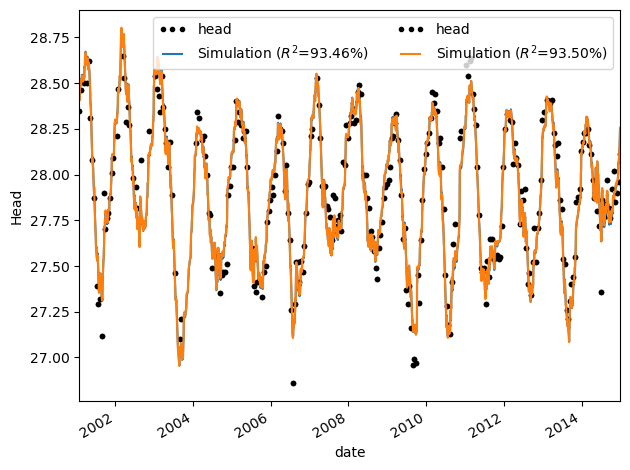

In [11]:
ax = ml.plot()  # Pastas-Modflow
mlexp.plot(ax=ax);  # Pastas-Exponential